# Generative Adversarial Network

- https://github.com/znxlwm/pytorch-generative-model-collections

In [24]:
import os
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
cuda = torch.cuda.is_available()
if cuda:
    print('cuda available!')

In [3]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.ConvTranspose2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()

In [6]:
class Generator(nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()
        
        self.fc = nn.Sequential(
            nn.Linear(62, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 128 * 7 * 7),
            nn.BatchNorm1d(128 * 7 * 7),
            nn.ReLU(),
        )
        
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid(),
        )
        
        initialize_weights(self)

    def forward(self, input):
        x = self.fc(input)
        x = x.view(-1, 128, 7, 7)
        x = self.deconv(x)
        return x

class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
        )
        
        self.fc = nn.Sequential(
            nn.Linear(128 * 7 * 7, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1),
            nn.Sigmoid(),
        )
        
        initialize_weights(self)
    
    def forward(self, input):
        x = self.conv(input)
        x = x.view(-1, 128 * 7 * 7)
        x = self.fc(x)
        return x

In [7]:
# hyperparameters
batch_size = 128
lr = 0.0002
z_dim = 62
num_epochs = 25
sample_num = 16
log_dir = './logs'

In [9]:
# initialize network
G = Generator()
D = Discriminator()
if cuda:
    G.cuda()
    D.cuda()

# optimizer
G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

# loss
criterion = nn.BCELoss()

# load dataset
transform = transforms.Compose([
    transforms.ToTensor()
])
dataset = datasets.FashionMNIST('data/fashion-mnist', train=True, download=True, transform=transform)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)        

Processing...
Done!


(-0.5, 145.5, 145.5, -0.5)

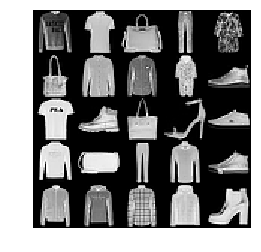

In [25]:
# データの可視化
def imshow(img):
    npimg = img.numpy()
    # [c, h, w] => [h, w, c]
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

images, labels = iter(data_loader).next()
images, labels = images[:25], labels[:25]
imshow(make_grid(images, nrow=5, padding=1))
plt.axis('off')

In [14]:
def train(D, G, criterion, D_optimizer, G_optimizer, data_loader):
    # 訓練モードへ
    D.train()
    G.train()

    # 本物のラベルは1
    y_real = Variable(torch.ones(batch_size, 1))
    # 偽物のラベルは0
    y_fake = Variable(torch.zeros(batch_size, 1))
    if cuda:
        y_real = y_real.cuda()
        y_fake = y_fake.cuda()

    D_running_loss = 0
    G_running_loss = 0
    for batch_idx, (real_images, _) in enumerate(data_loader):
        # 一番最後、バッチサイズに満たない場合は無視する
        if real_images.size()[0] != batch_size:
            break

        z = torch.rand((batch_size, z_dim))
        if cuda:
            real_images, z = real_images.cuda(), z.cuda()
        real_images, z = Variable(real_images), Variable(z)

        # Discriminatorの更新
        D_optimizer.zero_grad()

        # Discriminatorにとって本物画像の認識結果は1（本物）に近いほどよい
        D_real = D(real_images)
        D_real_loss = criterion(D_real, y_real)

        # DiscriminatorにとってGeneratorが生成した偽物画像の認識結果は0（偽物）に近いほどよい
        fake_images = G(z)
        D_fake = D(fake_images.detach())
        D_fake_loss = criterion(D_fake, y_fake)

        # 2つのlossの和を最小化する
        D_loss = D_real_loss + D_fake_loss
        D_loss.backward()
        D_optimizer.step()
        D_running_loss += D_loss.data[0]

        # Generatorの更新
        G_optimizer.zero_grad()

        # GeneratorにとってGeneratorが生成した画像の認識結果は1（本物）に近いほどよい
        fake_images = G(z)
        D_fake = D(fake_images)
        G_loss = criterion(D_fake, y_real)
        G_loss.backward()
        G_optimizer.step()
        G_running_loss += G_loss.data[0]
    
    D_running_loss /= len(data_loader)
    G_running_loss /= len(data_loader)
    
    return D_running_loss, G_running_loss

In [15]:
def generate(epoch, G, log_dir='logs'):
    G.eval()
    
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)

    # 生成のもとになる乱数を生成
    sample_z = torch.rand((64, z_dim))
    if cuda:
        sample_z = sample_z.cuda()
    sample_z = Variable(sample_z, volatile=True)
    
    # Generatorでサンプル生成
    samples = G(sample_z).data.cpu()
    save_image(samples, os.path.join(log_dir, 'epoch_%03d.png' % (epoch)))

In [ ]:
history = {}
history['D_loss'] = []
history['G_loss'] = []
for epoch in range(num_epochs):
    D_loss, G_loss = train(D, G, criterion, D_optimizer, G_optimizer, data_loader)
    
    print('epoch %d, D_loss: %.4f G_loss: %.4f' % (epoch + 1, D_loss, G_loss))
    history['D_loss'].append(D_loss)
    history['G_loss'].append(G_loss)
    
    # 特定のエポックでGeneratorから画像を生成してモデルも保存
    if epoch == 0 or epoch == 9 or epoch == 24:
        generate(epoch + 1, G, log_dir)
        torch.save(G.state_dict(), os.path.join(log_dir, 'G_%03d.pth' % (epoch + 1)))
        torch.save(D.state_dict(), os.path.join(log_dir, 'D_%03d.pth' % (epoch + 1)))

# 学習履歴を保存
with open(os.path.join(log_dir, 'history.pkl'), 'wb') as f:
    pickle.dump(history, f)

## 結果の分析

In [16]:
with open(os.path.join(log_dir, 'history.pkl'), 'rb') as f:
    history = pickle.load(f)

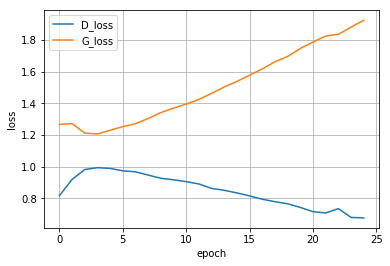

In [17]:
D_loss, G_loss = history['D_loss'], history['G_loss']
plt.plot(D_loss, label='D_loss')
plt.plot(G_loss, label='G_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()

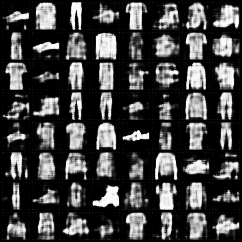

In [18]:
from IPython.display import Image
Image('logs/epoch_001.png')

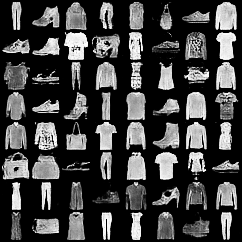

In [19]:
from IPython.display import Image
Image('logs/epoch_010.png')

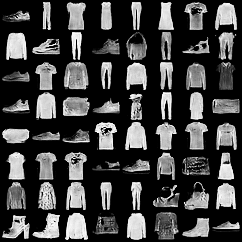

In [20]:
from IPython.display import Image
Image('logs/epoch_025.png')